In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.cuda.amp import autocast, GradScaler
from sklearn.manifold import TSNE
torch.manual_seed(42)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()

        self.dense1 = nn.Linear(784, 500)
        self.dense2 = nn.Linear(500, 500)
        self.dense3 = nn.Linear(500, latent_dim)

    def sample(self, alpha_hat):
        u = torch.rand(size=alpha_hat.size(), requires_grad=True).to(device)
        v = torch.pow(u * alpha_hat * torch.exp(torch.lgamma(alpha_hat)),1.0/alpha_hat)
        z = v / torch.sum(v)
        return z

    def forward(self, x):
        alpha_hat = x.view(-1, 28*28)
        alpha_hat = F.relu(self.dense1(alpha_hat))
        alpha_hat = F.relu(self.dense2(alpha_hat))
        alpha_hat = F.softplus(self.dense3(alpha_hat))
        z = self.sample(alpha_hat)
        return z, alpha_hat

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.dense1 = nn.Linear(latent_dim, 500)
        self.dense2 = nn.Linear(500, 28*28)

    def forward(self, x):
        x_hat = F.relu(self.dense1(x))
        return self.dense2(x_hat)

In [3]:
class DirVAE(nn.Module):
    def __init__(self, latent_dim):
        super(DirVAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
    
    def forward(self, x):
        z, alpha_hat = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, alpha_hat, z

In [4]:
def ELBO(x_hat, x, alpha_hat, alpha):
    
    likelihood = F.binary_cross_entropy_with_logits(x_hat, x.view(-1, 28*28), reduction='sum')
    
    lgamma_alpha = torch.lgamma(alpha).to(device)
    lgamma_alpha_hat = torch.lgamma(alpha_hat).to(device)
    digamma_alpha_hat = torch.digamma(alpha_hat).to(device)
    
    kld = torch.sum(lgamma_alpha - lgamma_alpha_hat + (alpha_hat - alpha) * digamma_alpha_hat)
    
#     if torch.isnan(likelihood):
#         print('LIKELIHOOD IS NAN')
        
#     if torch.isnan(kld):
#         print('KLD IS NAN') 

    return likelihood + kld

In [21]:
weights_path = '/kaggle/input/weights-and-alpha/model.pth'
#alpha = pd.read_csv('/kaggle/input/weights-and-alpha/alpha.csv')
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
model = DirVAE(50).to(device)

In [22]:
model.load_state_dict(torch.load(weights_path))
model.eval()

DirVAE(
  (encoder): Encoder(
    (dense1): Linear(in_features=784, out_features=500, bias=True)
    (dense2): Linear(in_features=500, out_features=500, bias=True)
    (dense3): Linear(in_features=500, out_features=50, bias=True)
  )
  (decoder): Decoder(
    (dense1): Linear(in_features=50, out_features=500, bias=True)
    (dense2): Linear(in_features=500, out_features=784, bias=True)
  )
)

In [34]:
test_data = datasets.MNIST('../data', train=False, download=True, transform=transforms.ToTensor())
targets = test_data.targets.numpy()

In [35]:
test_data = test_data.data.float() / 255.0
x_hat, alpha_hat, z = model(test_data.to(device))

In [38]:
targets.shape

(10000,)

In [39]:
z = z.to('cpu').detach().numpy()

tsne = TSNE(n_components=2)

X = tsne.fit_transform(z)

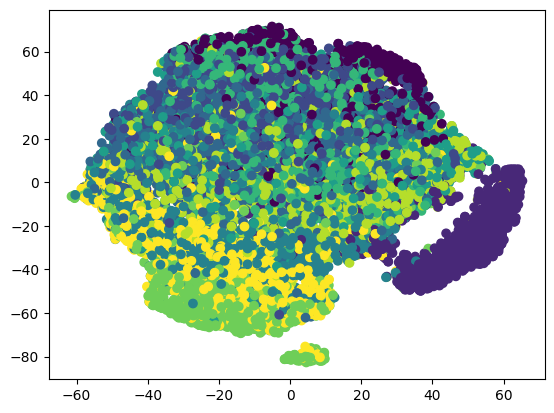

In [41]:
plt.scatter(X[:,0],X[:,1], c=targets)
plt.show()